# Librerias

In [1]:
import dataAcquisition
import ReparameterizationTrick
import Encoder
import Decoder
import VAE
import loss
import train
import Predictor
import importlib
import numpy as np

#

# Data adquisition

In [2]:
importlib.reload(dataAcquisition)
x_train, x_val, y_train, y_val, average_image, x_train_mix, x_test_mix,x_train_1, y_train_1 =  dataAcquisition.data_adquistion()

x_train(60k).shape:       (60000, 28, 28)
x_train_C.shape:     (55000, 28, 28, 1)
x_val_C.shape:     (5000, 28, 28, 1)
x_test_C.shape:      (10000, 28, 28, 1)
x_train.shape:       (55000, 28, 28)
x_val.shape:       (5000, 28, 28)
x_test.shape:       (10000, 28, 28)
x_train_1.shape:    (55000, 28, 28)
y_train_1.shape:      (55000, 10)
x_train_mix.shape:  (55000, 28, 28)
x_test_1.shape:    (10000, 28, 28)
y_test_1.shape:      (10000, 10)
x_test_mix.shape:  (10000, 28, 28)


# Encoder

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 784)       │          0 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 794)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ encoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    101,760 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,276 (399.52 KB)

 Trainable params: 102,276 (399.52 KB)

 Non-trainable params: 0 (0.00 B)

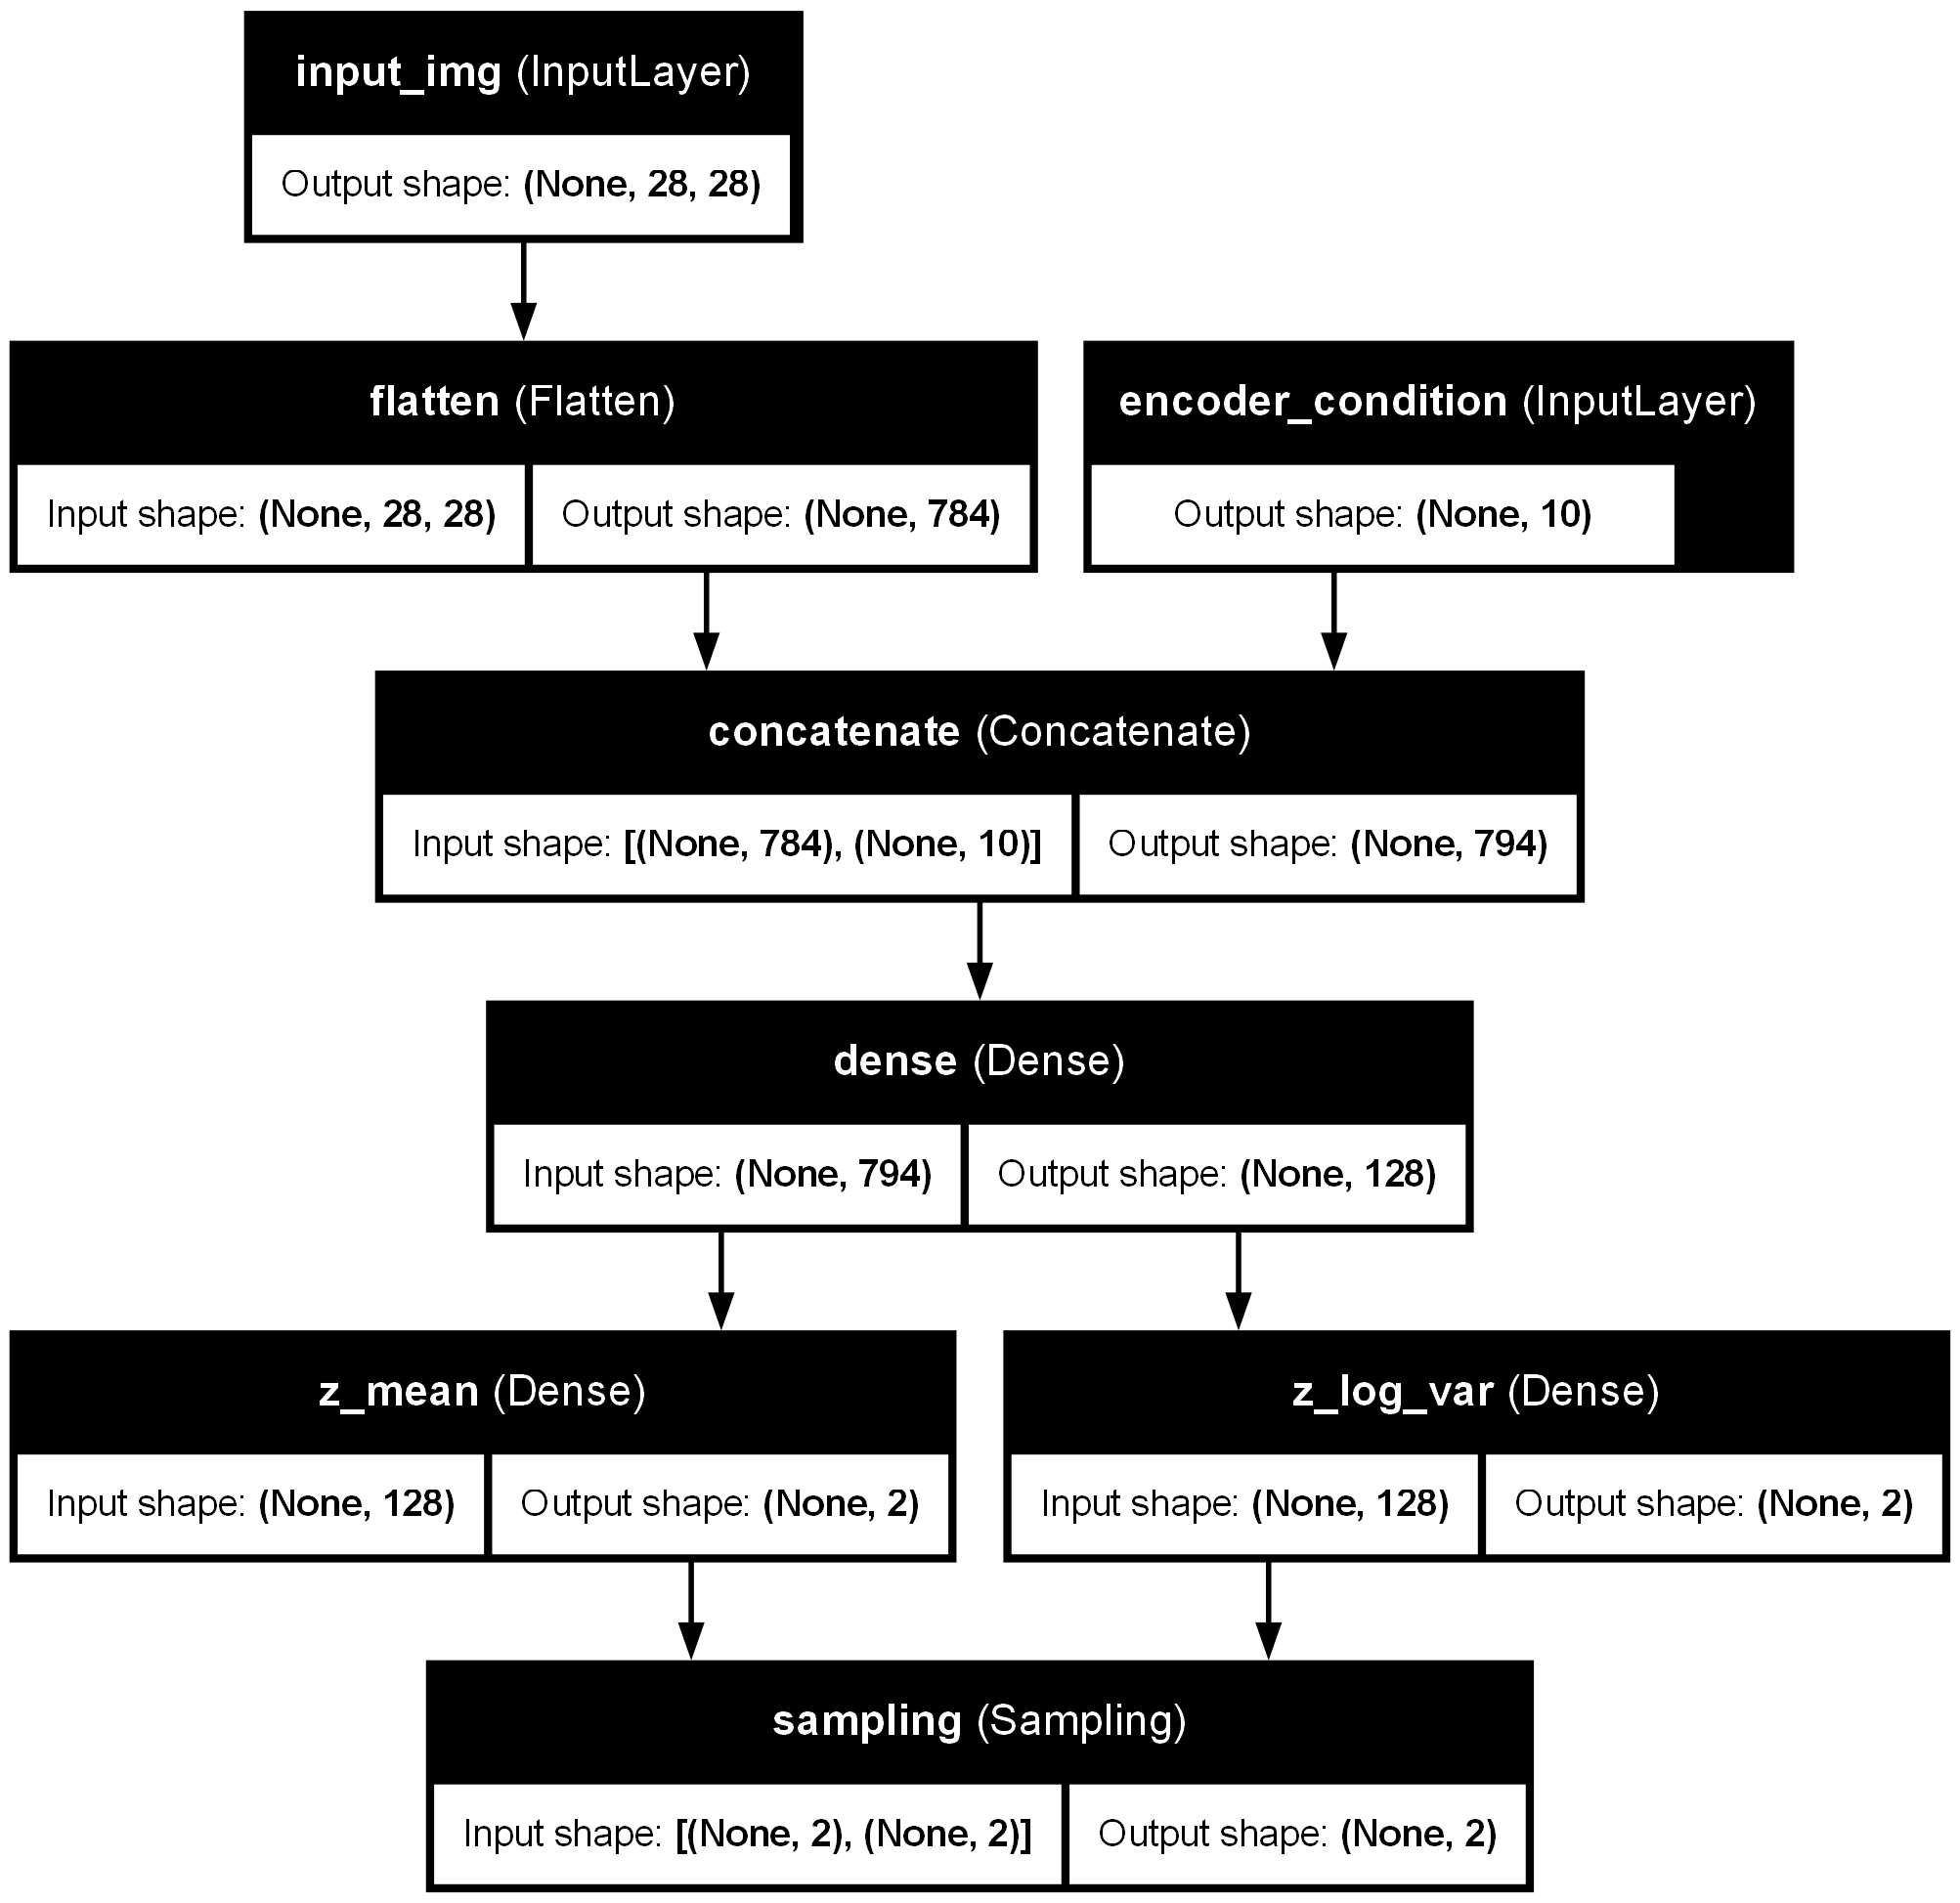

In [3]:
importlib.reload(Encoder)
encoder = Encoder.encoder(x_train, y_train)


# Decoder


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ z_sampling          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12)        │          0 │ z_sampling[0][0], │
│ (Concatenate)       │                   │            │ decoder_conditio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      1,664 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 784)       │    101,136 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28, 1) │          0 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 102,800 (401.56 KB)

 Trainable params: 102,800 (401.56 KB)

 Non-trainable params: 0 (0.00 B)

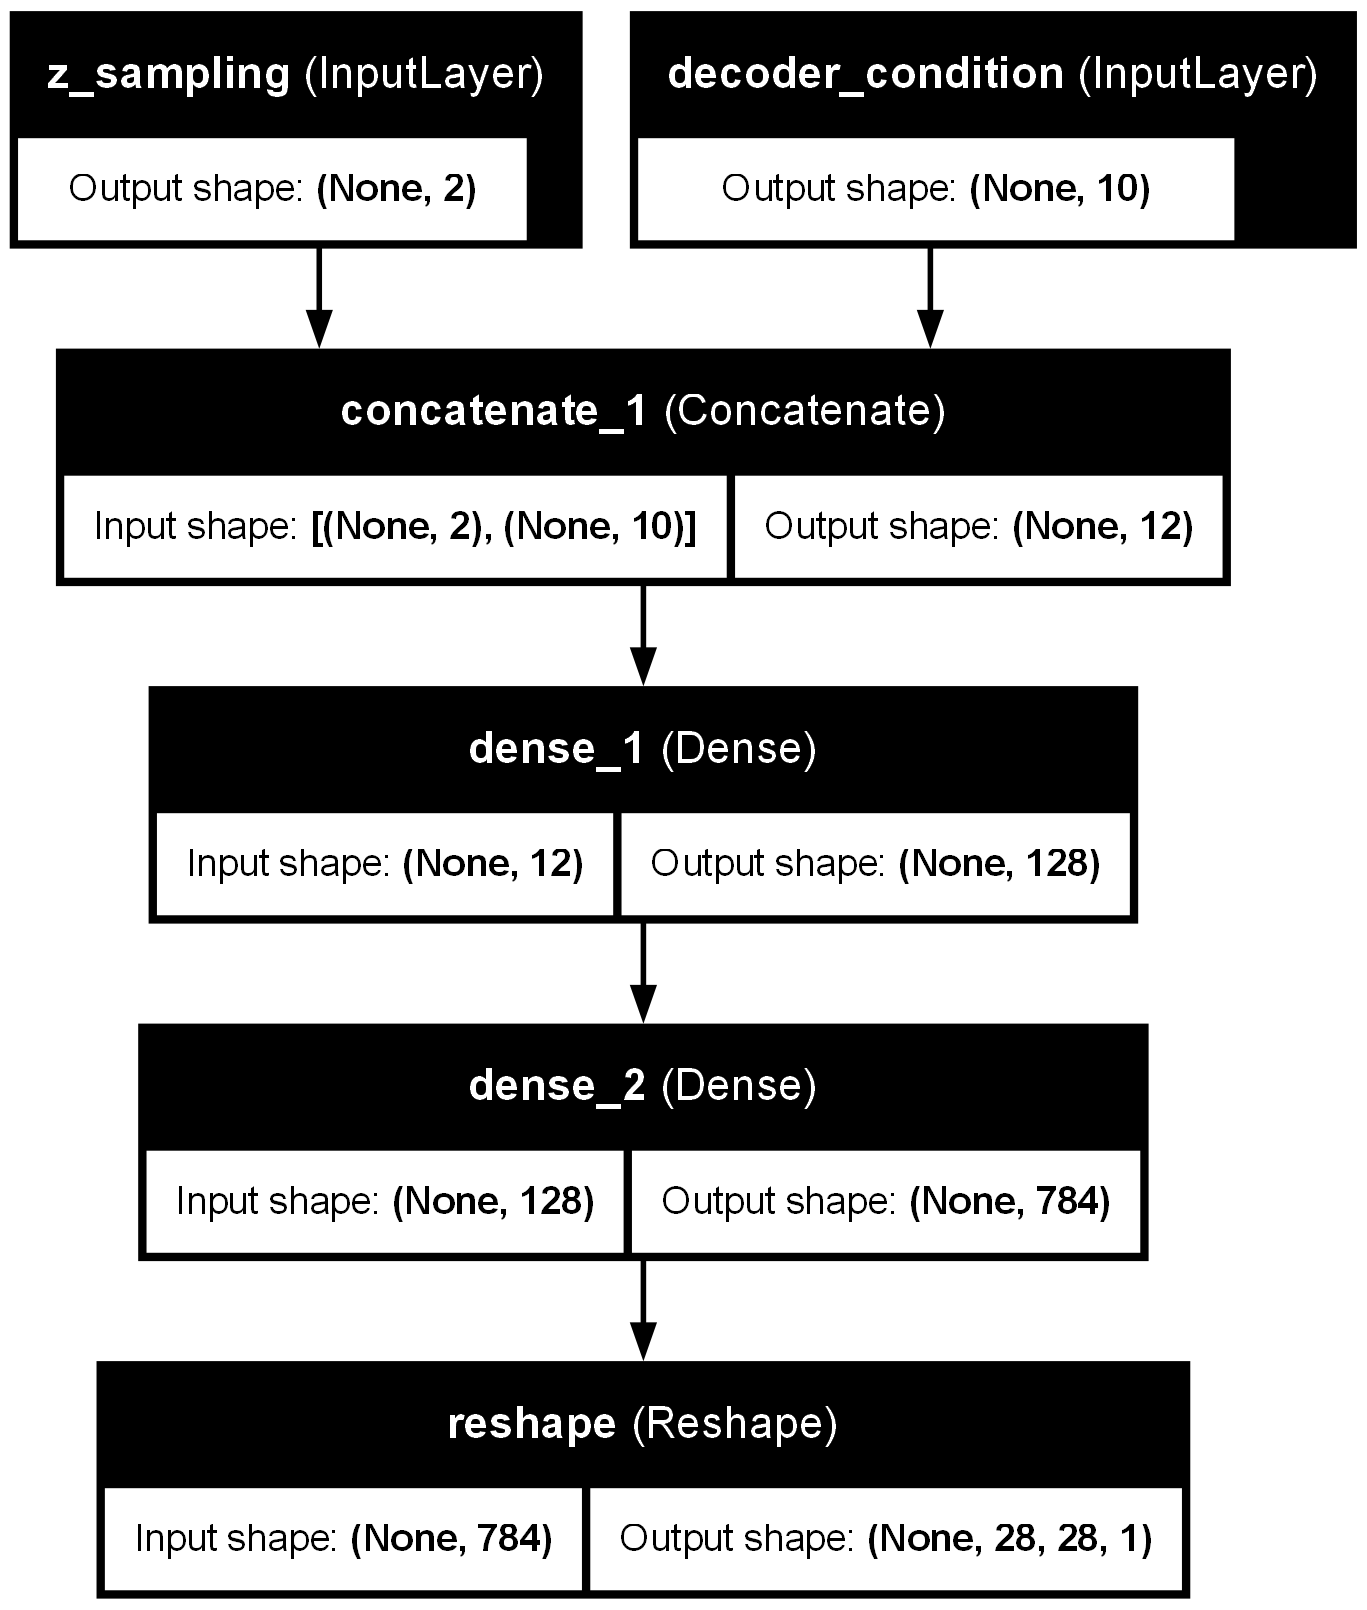

In [4]:
importlib.reload(Decoder)
decoder = Decoder.decoder(x_train, y_train)

VAE

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_condition   │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 2),       │    102,276 │ input_img[0][0],  │
│ (Functional)        │ (None, 2), (None, │            │ encoder_conditio… │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 28, 28, 1) │    102,800 │ encoder[0][2],    │
│ (Functional)        │                   │            │ encoder_conditio… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 205,076 (801.08 KB)

 Trainable params: 205,076 (801.08 KB)

 Non-trainable params: 0 (0.00 B)

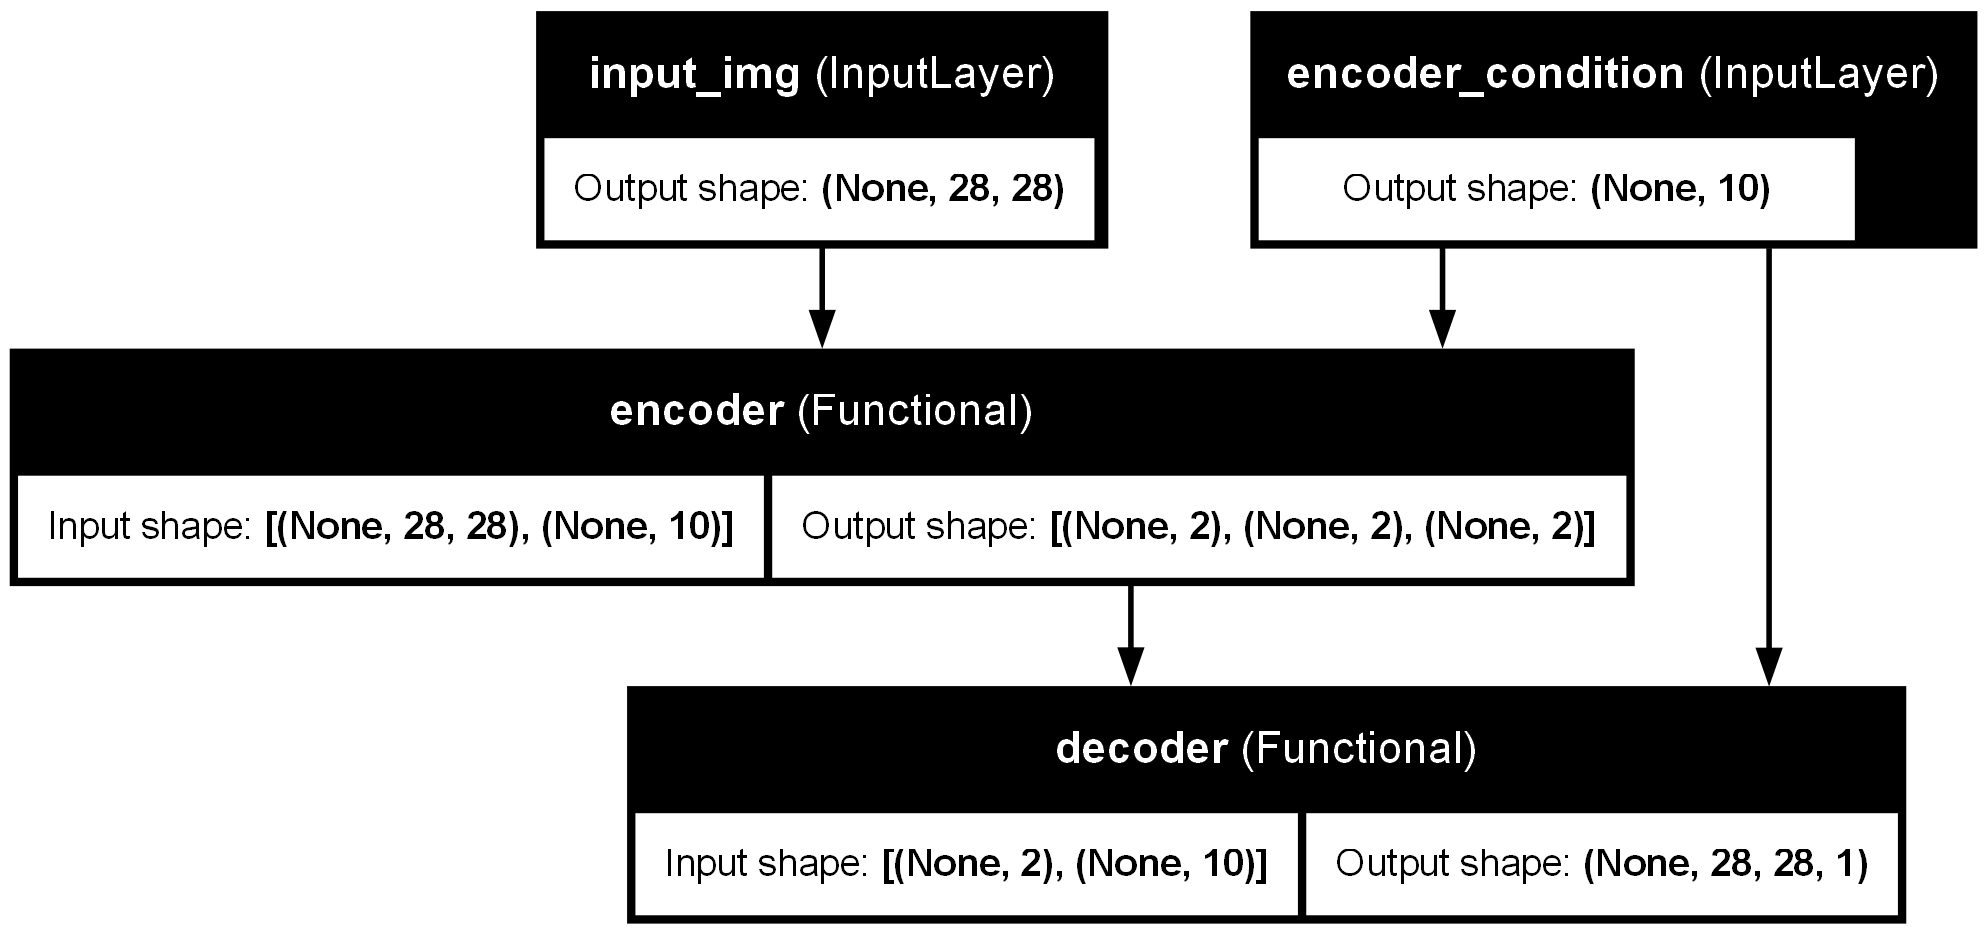

In [5]:
importlib.reload(VAE)
n_cond = np.shape(y_train)[1]  
vae =  VAE.Vae(encoder,decoder)

# Compile

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


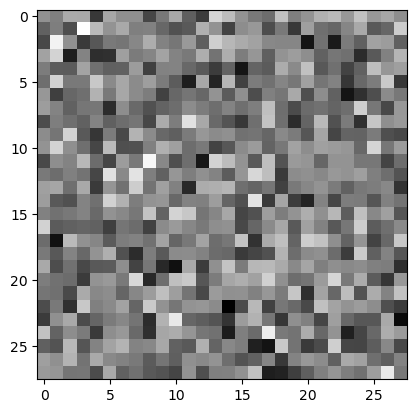

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Optimizer ------------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile --------------------------------------------------------------------
vae.compile(optimizer, loss=loss.vae_loss) #cambiar nombre

img = np.expand_dims(x_train[0], axis=0)
cond = np.expand_dims(y_train[0], axis=0)
salida = vae.predict([img, cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

# Train

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 68.9921 - val_loss: 39.5427
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


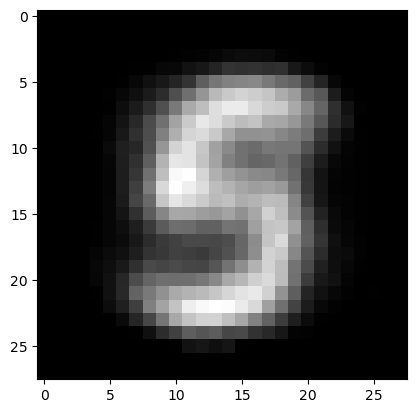

430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 39.0499 - val_loss: 35.4767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


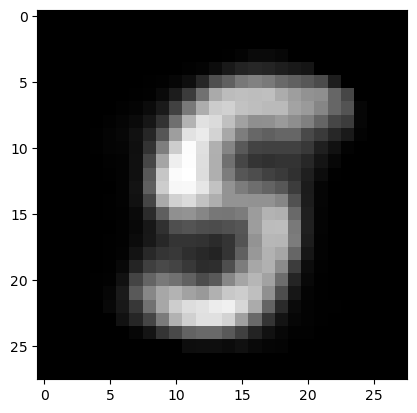

430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 35.6021 - val_loss: 33.7383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


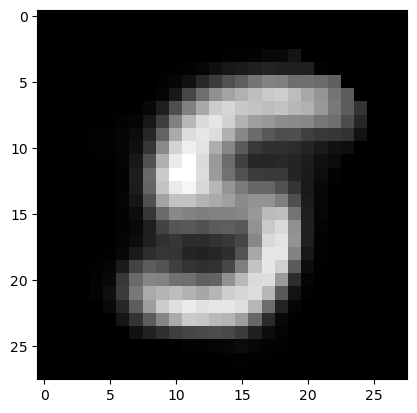

430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 34.0731 - val_loss: 32.5891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


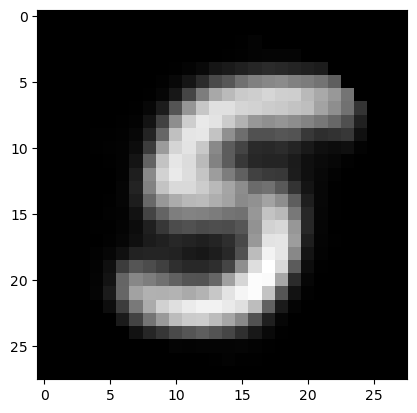

430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 33.0384 - val_loss: 31.8044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


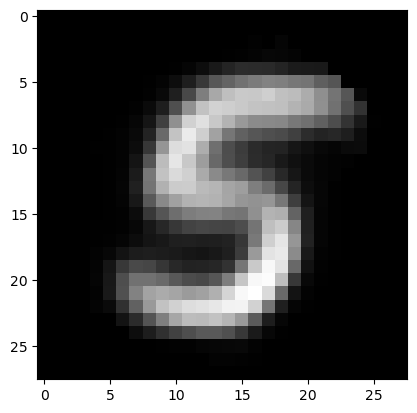

In [7]:
importlib.reload(train)
salida = vae.predict([img, cond])
reconstruccion = salida[0].reshape(28, 28)
plt.imshow(reconstruccion, cmap='gray')

for i in range(5):
    train.train(vae,x_train, y_train, x_val, y_val)
    salida = vae.predict([img, cond])
    reconstruccion = salida[0].reshape(28, 28)
    plt.imshow(reconstruccion, cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


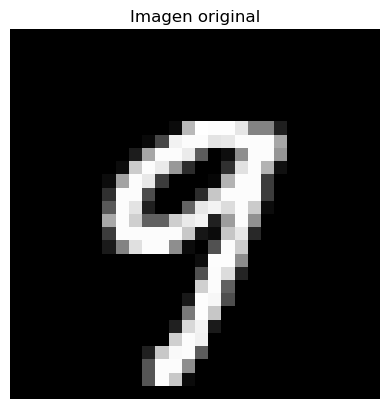

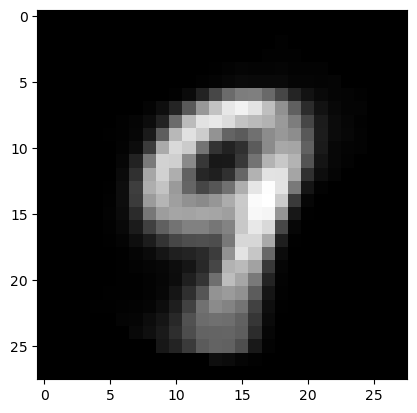

In [8]:
img = np.expand_dims(x_train[45], axis=0)
cond = np.expand_dims(y_train[45], axis=0)
salida = vae.predict([img, cond])

reconstruccion = salida[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()
plt.imshow(reconstruccion, cmap='gray')

In [9]:
importlib.reload(Predictor)
predictor_c = Predictor.predictor()

TypeError: 'module' object is not callable. Did you mean: 'ReshapeLayer.ReshapeLayer(...)'?

(1, 28, 28)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


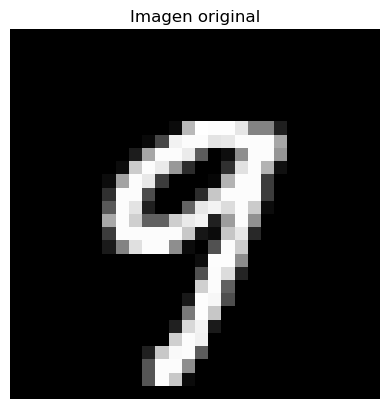

In [ ]:
importlib.reload(Predictor)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
predictor_c.compile(optimizer, loss="categorical_crossentropy")
print(img.shape)
prediccion = np.argmax( predictor_c.predict(img))
img[0].reshape(28, 28)
plt.imshow(img[0], cmap='gray')
plt.title("Imagen original")
plt.axis('off')
plt.show()


In [ ]:
for i in range(5): 
    #reconstruccion = prediccion[0].reshape(28, 28)
    print(f"prediccion  {prediccion}")
    prediccion = np.argmax(predictor_c.predict(img))


    predictor_c.fit(
        x=x_train,
        y=y_train,
        batch_size=128,
        epochs=1,
        validation_data=(x_val, y_val)  # Include validation data
        )

prediccion  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.7238 - val_loss: 0.1198
prediccion  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1160 - val_loss: 0.0723
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0737 - val_loss: 0.0680
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0586 - val_loss: 0.0624
prediccion  9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0466 - val_loss: 0.0648


In [ ]:
import inferencias
importlib.reload(inferencias)
#importlib.reload(outcomes)
print(x_train.shape)
inferencias.inferncia_modelo(x_train,x_train_1,y_train,predictor_c,encoder,decoder,y_train_1)


(55000, 28, 28)
(55000, 28, 28)
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
(55000, 28, 28)
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
ITERACIÓN A:  0
x_decoded_1 dim

(55000, 28, 28)
x_decoded_1 dim

(55000, 28, 28)
Dimensiones de x 

(55000, 28, 28)
(55000, 28, 28)
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


InvalidArgumentError: {{function_node __wrapped__Equal_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [10] vs. [55000] [Op:Equal] name: 